In [1]:
import pathlib
import sqlite3

# impot open cv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cytotable import convert
from skimage import io

In [2]:
# set paths
dest_datatype = "parquet"

# common configurations to use based on typical CellProfiler SQLite outputs
preset = "cellprofiler_sqlite_pycytominer"

input_dir = pathlib.Path("../../data/4.sqlite_output")

# directory where parquet files are saved to
output_dir = pathlib.Path("../../data/5.converted_data")
output_dir.mkdir(exist_ok=True)

source_path = input_dir / "output.sqlite"
dest_path = output_dir / f"output.{dest_datatype}"

In [3]:
# Read in the sqlite file via sqlite3
conn = sqlite3.connect(source_path)

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables = tables["name"].values
tables

array(['Per_Object', 'Per_Image', 'Experiment', 'sqlite_sequence',
       'Experiment_Properties', 'Per_Experiment', 'Per_RelationshipTypes',
       'Per_Relationships'], dtype=object)

In [4]:
images_df = pd.read_sql_query(f"SELECT * FROM Per_Image", conn)
# select columns to keep in the final dataframe
columns_to_keep = ["ImageNumber", "Image_FileName_OP"]
images_df = images_df[columns_to_keep]

In [5]:
query = "SELECT * FROM Per_Object"
df = pd.read_sql_query(query, conn)


# combine the two dataframes on ImageNumber
df = df.merge(images_df, on="ImageNumber")
conn.close()

In [6]:
# get the column names that have BoundingBox in them
bounding_box_cols = [x for x in df.columns if "BoundingBox" in x]
# get the column names that have Location in them
location_cols = [x for x in df.columns if "Location" in x]
# get the column names that have Center in them
center_cols = [x for x in df.columns if "Center" in x]
# manual list
manual_cols = [
    "ImageNumber",
    "Image_FileName_OP",
    "ObjectNumber",
    "ConvertImageToObjects_Number_Object_Number",
]

final_metadata_cols = manual_cols + bounding_box_cols + location_cols + center_cols

In [7]:
# select all of the metadata columns
metadata_df = df[final_metadata_cols]
metadata_df.head()
# add "Metadata to the front of the column names"
metadata_df.columns = ["Metadata_" + x for x in metadata_df.columns]
metadata_df.head()

df = df.drop(columns=final_metadata_cols)

In [8]:
# get the ConvertImageToObjects columns and remove the ConvertImageToObjects_ prefix
convert_cols = [x for x in df.columns if "ConvertImageToObjects" in x]
convert_df = df[convert_cols]
convert_df.columns = [
    x.replace("ConvertImageToObjects_", "") for x in convert_df.columns
]
convert_df.head()

,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,AreaShape_CentralMoment_1_3,AreaShape_CentralMoment_2_0,...,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
0,20280.0,20280.0,3.734471e-10,7.340911e+07,-7.695650e+08,8.458301e-11,-1.355732e+07,4.070040e+08,-4.634796e+10,2.403364e+07,...,7.464876,7.467345,5612.372236,5428.628802,5561.586302,5533.247922,1445.881749,1454.141113,1446.734008,1450.384438
1,14172.0,14172.0,-2.144418e-10,1.818271e+07,7.916593e+07,7.861445e-11,-1.733839e+07,8.242123e+07,-4.511576e+10,3.767149e+07,...,7.141160,7.132935,2982.924894,2909.198554,3033.891669,2977.193911,783.832997,791.301882,783.724828,785.312031
2,23382.0,23382.0,2.982574e-10,4.784597e+07,-4.294114e+07,-1.205080e-11,4.381698e+06,1.418514e+07,4.596719e+10,7.073616e+07,...,7.176389,7.178850,2657.560764,2585.841084,2693.672231,2609.286917,708.550385,712.248756,707.462470,711.379296
3,1.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,22733.0,22733.0,-1.477929e-10,3.325769e+07,2.370985e+08,1.956607e-09,-1.366386e+07,2.470910e+06,-7.703903e+10,8.110800e+07,...,7.495878,7.493400,5540.662495,5399.993202,5550.186485,5465.765338,1440.098393,1446.802584,1439.657643,1444.543367


In [9]:
# add the metadata and convert dataframes together
df = pd.concat([metadata_df, convert_df], axis=1)
duplicates = df.columns[df.columns.duplicated()].tolist()
print("Duplicate columns are:", duplicates)
# drop the duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
# filter out small objects
df = df[df["AreaShape_Area"] > 100]

Duplicate columns are: ['Metadata_ConvertImageToObjects_Location_CenterMassIntensity_X_OP', 'Metadata_ConvertImageToObjects_Location_CenterMassIntensity_Y_OP', 'Metadata_ConvertImageToObjects_Location_CenterMassIntensity_Z_OP', 'Metadata_ConvertImageToObjects_Location_Center_X', 'Metadata_ConvertImageToObjects_Location_Center_Y', 'Metadata_ConvertImageToObjects_Location_Center_Z']


In [10]:
# split the dataframe into 3 dataframes by genotype
df1 = df[df["Metadata_Image_FileName_OP"].str.contains("wt")]
df2 = df[df["Metadata_Image_FileName_OP"].str.contains("unsel")]
df3 = df[df["Metadata_Image_FileName_OP"].str.contains("high")]

print(f"Original dataframe shape: {df.shape}")
print(f"WT dataframe shape: {df1.shape}")
print(f"Unselected dataframe shape: {df2.shape}")
print(f"High dataframe shape: {df3.shape}")

# df1 is the wt dataframe
# df2 is the unsel dataframe
# df3 is the high dataframe

# filter the df to have the object with the largest area
df3 = df3.loc[df3.groupby("Metadata_ImageNumber")["AreaShape_Area"].idxmax()]

# filter the df to have the 2 objects with the 2 largest areas
df1 = df1.loc[
    df1.groupby("Metadata_ImageNumber")["AreaShape_Area"]
    .nlargest(2)
    .index.get_level_values(1)
]
df2 = df2.loc[
    df2.groupby("Metadata_ImageNumber")["AreaShape_Area"]
    .nlargest(2)
    .index.get_level_values(1)
]

print(f"Filtered dataframe shape: {df.shape}")
print(f"Filtered WT dataframe shape: {df1.shape}")
print(f"Filtered Unselected dataframe shape: {df2.shape}")
print(f"Filtered High dataframe shape: {df3.shape}")


df = pd.concat([df1, df2, df3])

Original dataframe shape: (153, 283)
WT dataframe shape: (56, 283)
Unselected dataframe shape: (60, 283)
High dataframe shape: (37, 283)
Filtered dataframe shape: (153, 283)
Filtered WT dataframe shape: (56, 283)
Filtered Unselected dataframe shape: (52, 283)
Filtered High dataframe shape: (28, 283)


Theorectical number of objects:  

2 sides (L and R)   
2 bones per side for unsel and wt, 1 bone per side for high  
15 fish (1-15) per genotype   
3 genotypes (wt, unsel, high)  

2 x 15 = 30 objects for high  
2 x 2 x 15 x 2 = 60 objects for wt  
between 2 x 2 x 15 x 2 = 30 and 2 x 2 x 15 x 3 = 60 objects for unsel  

Total = 120-150 objects theoretically  

In [11]:
# keep the two largest areas for each image
df = df.sort_values(by=["Metadata_ImageNumber", "AreaShape_Area"], ascending=False)

# get the top two largest areas for each image
df = df.groupby("Metadata_ImageNumber").head(2)
df.rename(
    columns={"Number_Object_Number": "Metadata_Number_Object_Number"}, inplace=True
)
df.shape

(136, 283)

## Annotate objects

In [12]:
# sort by Metadata_ImageNumber
df = df.sort_values(by=["Metadata_ImageNumber"], ascending=True)
df.reset_index(drop=True, inplace=True)

In [13]:
input_dir = pathlib.Path("../../data/3.maximum_projections_and_masks").resolve()

In [14]:
# set the image size when printed
plt.rcParams["figure.figsize"] = (1, 1)

0 MAX_high_10_L.tiff


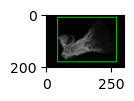

1 MAX_high_10_R.tiff


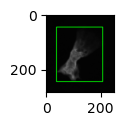

2 MAX_high_11_L.tiff


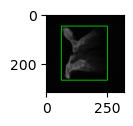

3 MAX_high_11_R.tiff


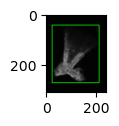

4 MAX_high_12_L.tiff


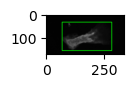

5 MAX_high_12_R.tiff


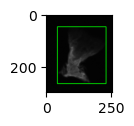

6 MAX_high_13_L.tiff


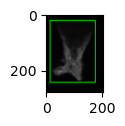

7 MAX_high_13_R.tiff


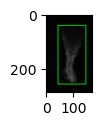

8 MAX_high_14_L.tiff


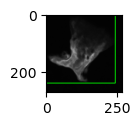

9 MAX_high_14_R.tiff


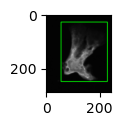

10 MAX_high_1_L.tiff


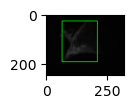

11 MAX_high_1_R.tiff


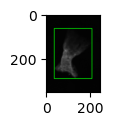

12 MAX_high_2_L.tiff


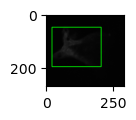

13 MAX_high_2_R.tiff


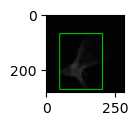

14 MAX_high_3_L.tiff


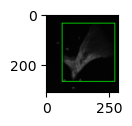

15 MAX_high_3_R.tiff


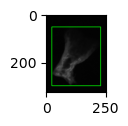

16 MAX_high_4_L.tiff


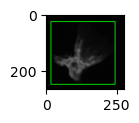

17 MAX_high_4_R.tiff


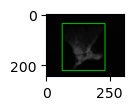

18 MAX_high_5_L.tiff


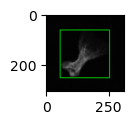

19 MAX_high_5_R.tiff


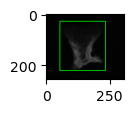

20 MAX_high_6_L.tiff


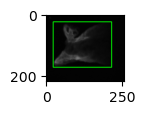

21 MAX_high_6_R.tiff


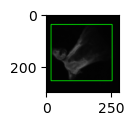

22 MAX_high_7_L.tiff


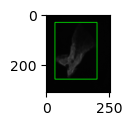

23 MAX_high_7_R.tiff


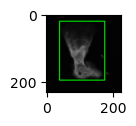

24 MAX_high_8_L.tiff


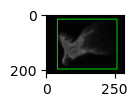

25 MAX_high_8_R.tiff


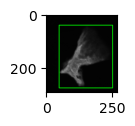

26 MAX_high_9_L.tiff


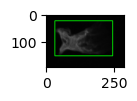

27 MAX_high_9_R.tiff


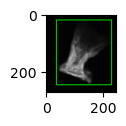

28 MAX_unsel_10_L.tiff


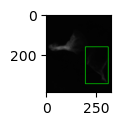

29 MAX_unsel_10_L.tiff


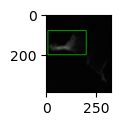

30 MAX_unsel_10_R.tiff


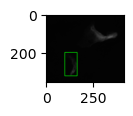

31 MAX_unsel_10_R.tiff


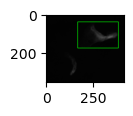

32 MAX_unsel_11_R.tiff


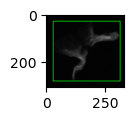

33 MAX_unsel_12_L.tiff


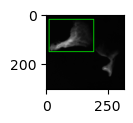

34 MAX_unsel_12_L.tiff


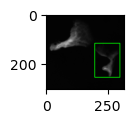

35 MAX_unsel_12_R.tiff


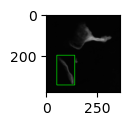

36 MAX_unsel_12_R.tiff


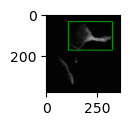

37 MAX_unsel_13_L.tiff


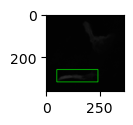

38 MAX_unsel_13_L.tiff


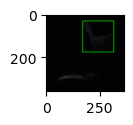

39 MAX_unsel_13_R.tiff


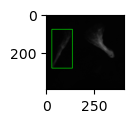

40 MAX_unsel_13_R.tiff


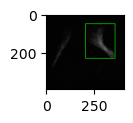

41 MAX_unsel_14_L.tiff


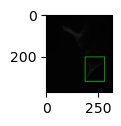

42 MAX_unsel_14_L.tiff


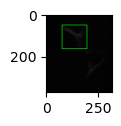

43 MAX_unsel_14_R.tiff


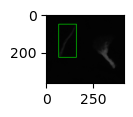

44 MAX_unsel_14_R.tiff


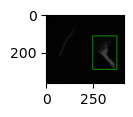

45 MAX_unsel_1_L.tiff


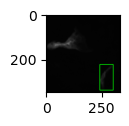

46 MAX_unsel_1_L.tiff


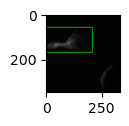

47 MAX_unsel_1_R.tiff


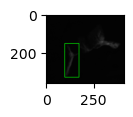

48 MAX_unsel_1_R.tiff


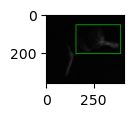

49 MAX_unsel_2_L.tiff


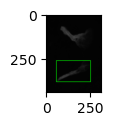

50 MAX_unsel_2_L.tiff


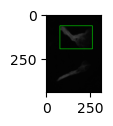

51 MAX_unsel_2_R.tiff


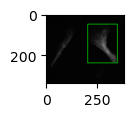

52 MAX_unsel_2_R.tiff


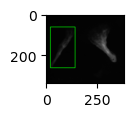

53 MAX_unsel_3_L.tiff


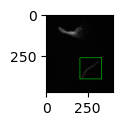

54 MAX_unsel_3_L.tiff


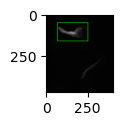

55 MAX_unsel_3_R.tiff


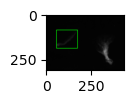

56 MAX_unsel_3_R.tiff


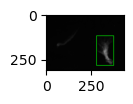

57 MAX_unsel_4_L.tiff


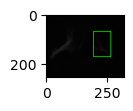

58 MAX_unsel_4_L.tiff


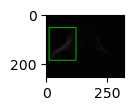

59 MAX_unsel_4_R.tiff


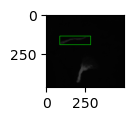

60 MAX_unsel_4_R.tiff


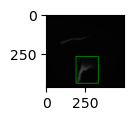

61 MAX_unsel_5_L.tiff


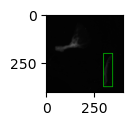

62 MAX_unsel_5_L.tiff


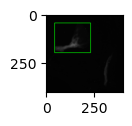

63 MAX_unsel_5_R.tiff


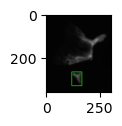

64 MAX_unsel_5_R.tiff


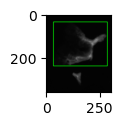

65 MAX_unsel_6_L.tiff


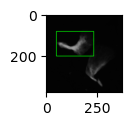

66 MAX_unsel_6_L.tiff


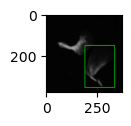

67 MAX_unsel_6_R.tiff


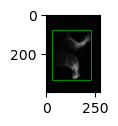

68 MAX_unsel_7_L.tiff


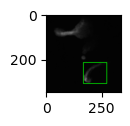

69 MAX_unsel_7_L.tiff


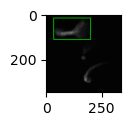

70 MAX_unsel_7_R.tiff


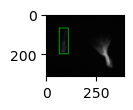

71 MAX_unsel_7_R.tiff


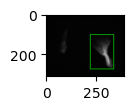

72 MAX_unsel_8_L.tiff


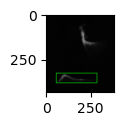

73 MAX_unsel_8_L.tiff


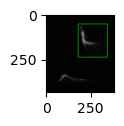

74 MAX_unsel_8_R.tiff


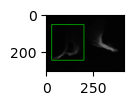

75 MAX_unsel_8_R.tiff


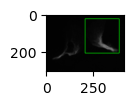

76 MAX_unsel_9_L.tiff


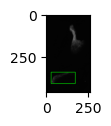

77 MAX_unsel_9_L.tiff


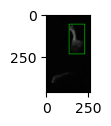

78 MAX_unsel_9_R.tiff


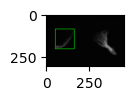

79 MAX_unsel_9_R.tiff


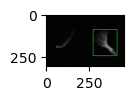

80 MAX_wt_10_L.tiff


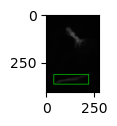

81 MAX_wt_10_L.tiff


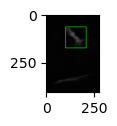

82 MAX_wt_10_R.tiff


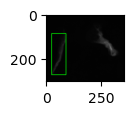

83 MAX_wt_10_R.tiff


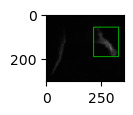

84 MAX_wt_11_L.tiff


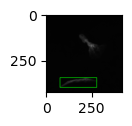

85 MAX_wt_11_L.tiff


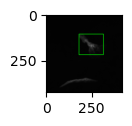

86 MAX_wt_11_R.tiff


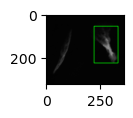

87 MAX_wt_11_R.tiff


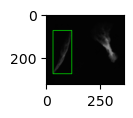

88 MAX_wt_12_L.tiff


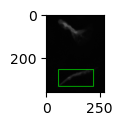

89 MAX_wt_12_L.tiff


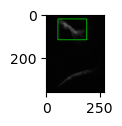

90 MAX_wt_12_R.tiff


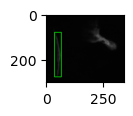

91 MAX_wt_12_R.tiff


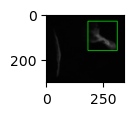

92 MAX_wt_13_L.tiff


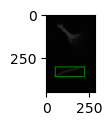

93 MAX_wt_13_L.tiff


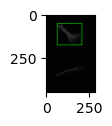

94 MAX_wt_13_R.tiff


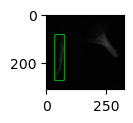

95 MAX_wt_13_R.tiff


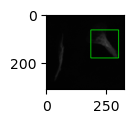

96 MAX_wt_14_L.tiff


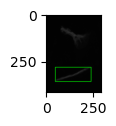

97 MAX_wt_14_L.tiff


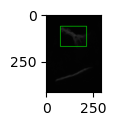

98 MAX_wt_14_R.tiff


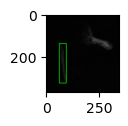

99 MAX_wt_14_R.tiff


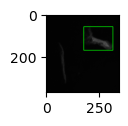

100 MAX_wt_1_L.tiff


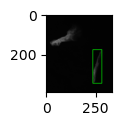

101 MAX_wt_1_L.tiff


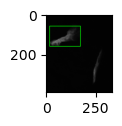

102 MAX_wt_1_R.tiff


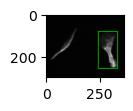

103 MAX_wt_1_R.tiff


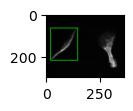

104 MAX_wt_2_L.tiff


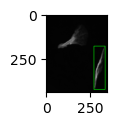

105 MAX_wt_2_L.tiff


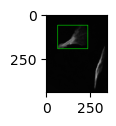

106 MAX_wt_2_R.tiff


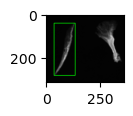

107 MAX_wt_2_R.tiff


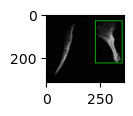

108 MAX_wt_3_L.tiff


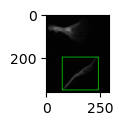

109 MAX_wt_3_L.tiff


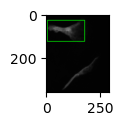

110 MAX_wt_3_R.tiff


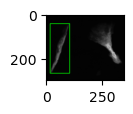

111 MAX_wt_3_R.tiff


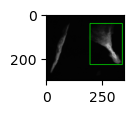

112 MAX_wt_4_L.tiff


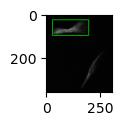

113 MAX_wt_4_L.tiff


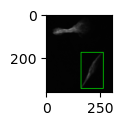

114 MAX_wt_4_R.tiff


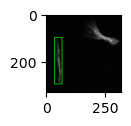

115 MAX_wt_4_R.tiff


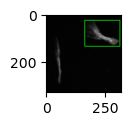

116 MAX_wt_5_L.tiff


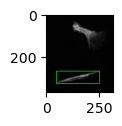

117 MAX_wt_5_L.tiff


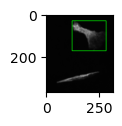

118 MAX_wt_5_R.tiff


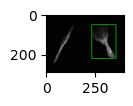

119 MAX_wt_5_R.tiff


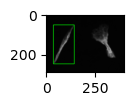

120 MAX_wt_6_L.tiff


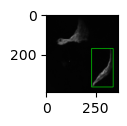

121 MAX_wt_6_L.tiff


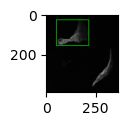

122 MAX_wt_6_R.tiff


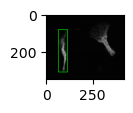

123 MAX_wt_6_R.tiff


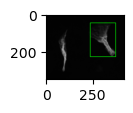

124 MAX_wt_7_L.tiff


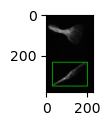

125 MAX_wt_7_L.tiff


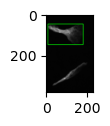

126 MAX_wt_7_R.tiff


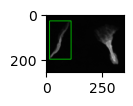

127 MAX_wt_7_R.tiff


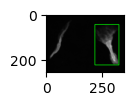

128 MAX_wt_8_L.tiff


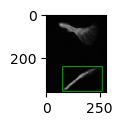

129 MAX_wt_8_L.tiff


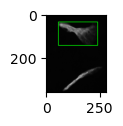

130 MAX_wt_8_R.tiff


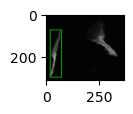

131 MAX_wt_8_R.tiff


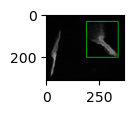

132 MAX_wt_9_L.tiff


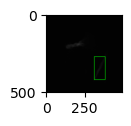

133 MAX_wt_9_L.tiff


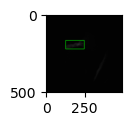

134 MAX_wt_9_R.tiff


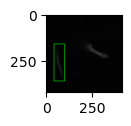

135 MAX_wt_9_R.tiff


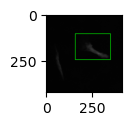

In [15]:
for i in range(df.shape[0]):

    image_path = df.loc[i, "Metadata_Image_FileName_OP"]
    print(i, image_path)
    image_path = input_dir / image_path
    x_min = df.loc[
        i, "Metadata_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_X"
    ].astype(int)
    x_max = df.loc[
        i, "Metadata_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_X"
    ].astype(int)
    y_min = df.loc[
        i, "Metadata_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_Y"
    ].astype(int)
    y_max = df.loc[
        i, "Metadata_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_Y"
    ].astype(int)
    # read the image
    img = cv2.imread(str(image_path))
    # draw the bounding box
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # show the image
    plt.imshow(img)
    plt.show()
    plt.close()

In [16]:
identity_list = [
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "both",
    "br",
    "op",
    "br",
    "op",
    "both",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "both",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "br",
    "op",
    "op",
    "br",
    "br",
    "op",
]
df["Metadata_identity"] = identity_list

In [17]:
# write the df to a parquet file
df.to_parquet(dest_path, index=False)